# Interest Rate Models

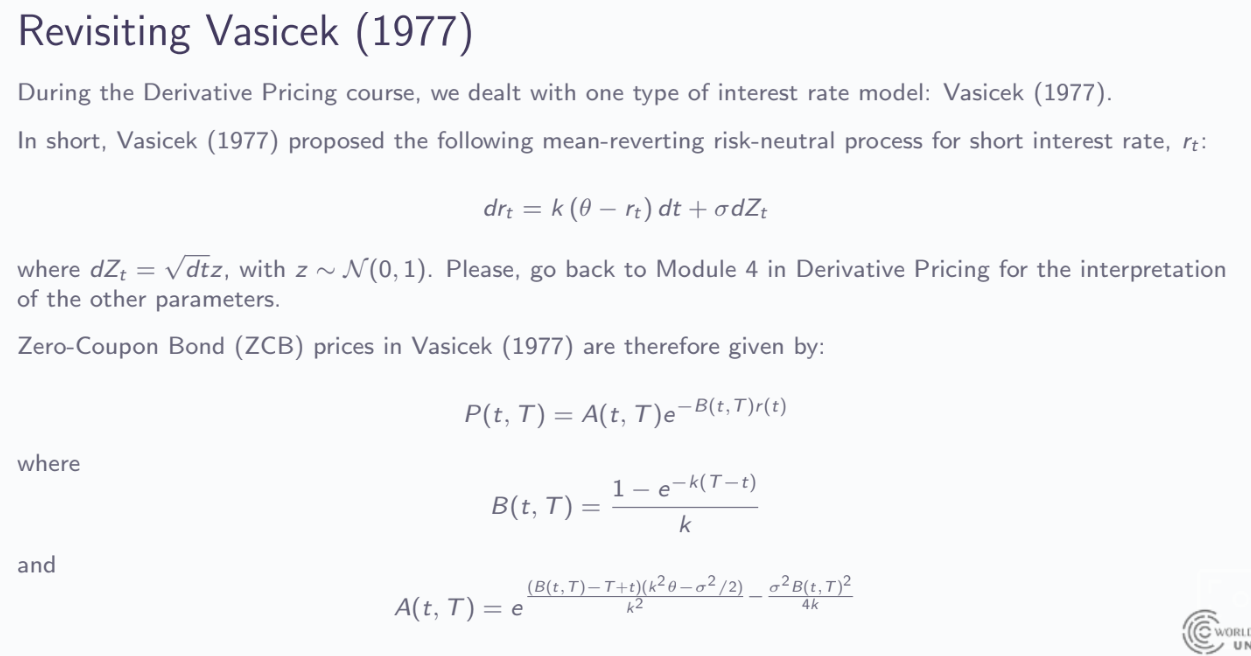

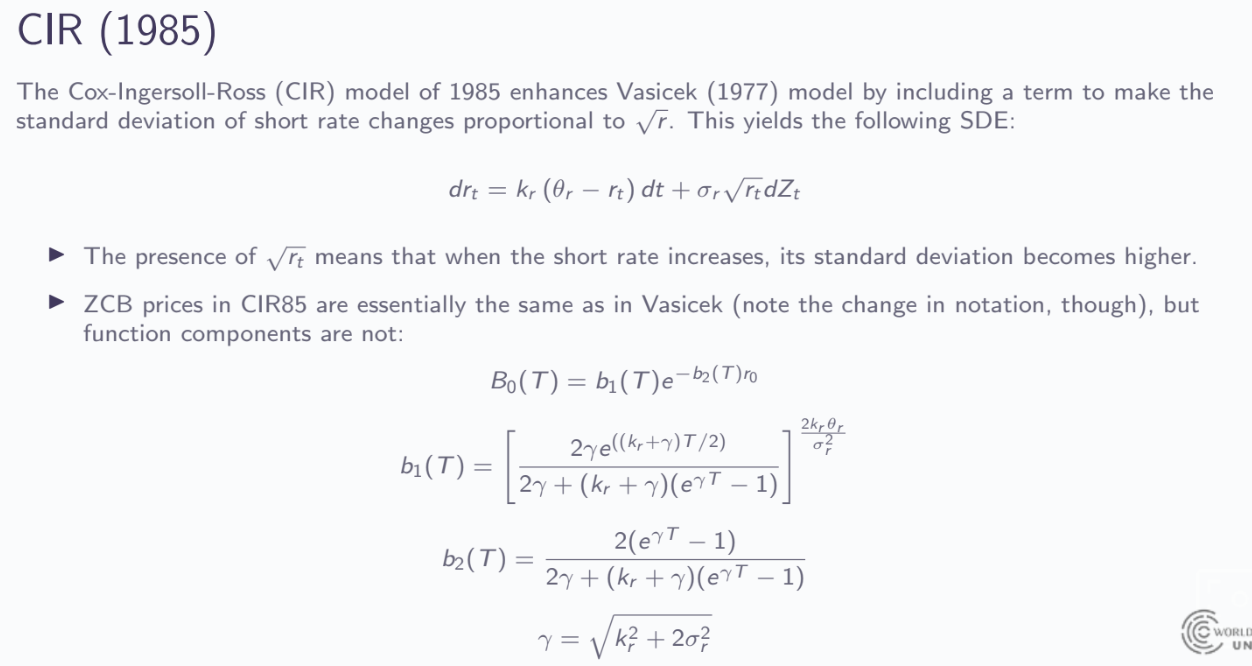

## **1. Vasicek (1977) Model**

We already know the form of Vasicek (1977) SDE and how to implement it in Python. Please go back to Module 4 in Derivative Pricing if you need a refresher on this.

The risk-neutral process for short rates in Vasicek (1977) is given by:
$$
\
\begin{equation*}
  dr_t = k(\theta-r_t)dt + \sigma dz_t
\end{equation*}
$$
\
where $dz_t = \sqrt{dt} z$, with $z \sim \mathcal{N}(0,1)$. 

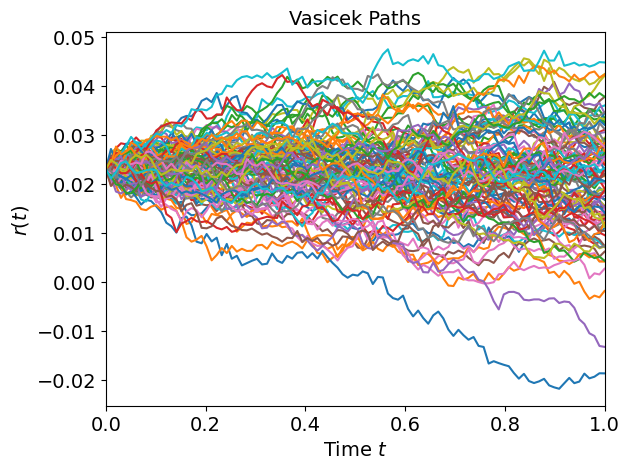

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def vasicek(r0, k, theta, sigma, T, N, M):
    dt = T / N
    rates = np.zeros((N, M))
    rates[0, :] = r0
    for j in range(M):
        for i in range(1, N):
            dr = (
                k * (theta - rates[i - 1, j]) * dt
                + sigma * np.sqrt(dt) * np.random.normal()
            )
            rates[i, j] = rates[i - 1, j] + dr
    return rates

M = 100  # Number of paths for MC
N = 100  # Number of steps
T = 1.0  # Maturity
r0 = 0.023
k = 0.20
theta = 0.01
sigma = 0.012
t = np.linspace(0, T, N)

rates = vasicek(r0, k, theta, sigma, T, N, M)

for j in range(M):
    plt.plot(t, rates[:, j])

plt.xlabel("Time $t$", fontsize=14)
plt.ylabel("$r(t)$", fontsize=14)
plt.title("Vasicek Paths", fontsize=14)
axes = plt.gca()
axes.set_xlim([0, T])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()


## **2. Cox-Ingersoll-Ross (1985) Model**

Now, let's undergo the same process with the CIR (1985) model, which is not so familiar to us, although it simply involves a small switch from Vasicek's SDE.

CIR (1985) model SDE has the following form:
$$
\
\
\begin{equation*}
  dr_t = k_r(\theta_r-r_t)dt + \sigma_r \sqrt{r_t} dz_t
\end{equation*}
$$

So, with just a couple small tweaks to the Vasicek (1977) function, we can get the one for CIR (1985):

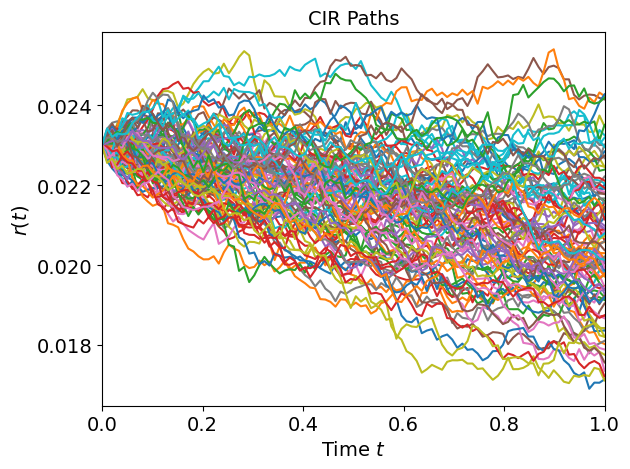

In [4]:
def cir(r0, k, theta, sigma, T, N, M):
    dt = T / N
    rates = np.zeros((N, M))
    rates[0, :] = r0
    for j in range(M):
        for i in range(1, N):
            dr = (
                k * (theta - rates[i - 1, j]) * dt
                + sigma
                * np.sqrt(dt)
                * np.sqrt(np.maximum(rates[i - 1, j], 0))
                * np.random.normal()
            )
            rates[i, j] = rates[i - 1, j] + dr
    return rates

rates_cir = cir(r0, k, theta, sigma, T, N, M)

for j in range(M):
    plt.plot(t, rates_cir[:, j])

plt.xlabel("Time $t$", fontsize=14)
plt.ylabel("$r(t)$", fontsize=14)
plt.title("CIR Paths", fontsize=14)
axes = plt.gca()
axes.set_xlim([0, T])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

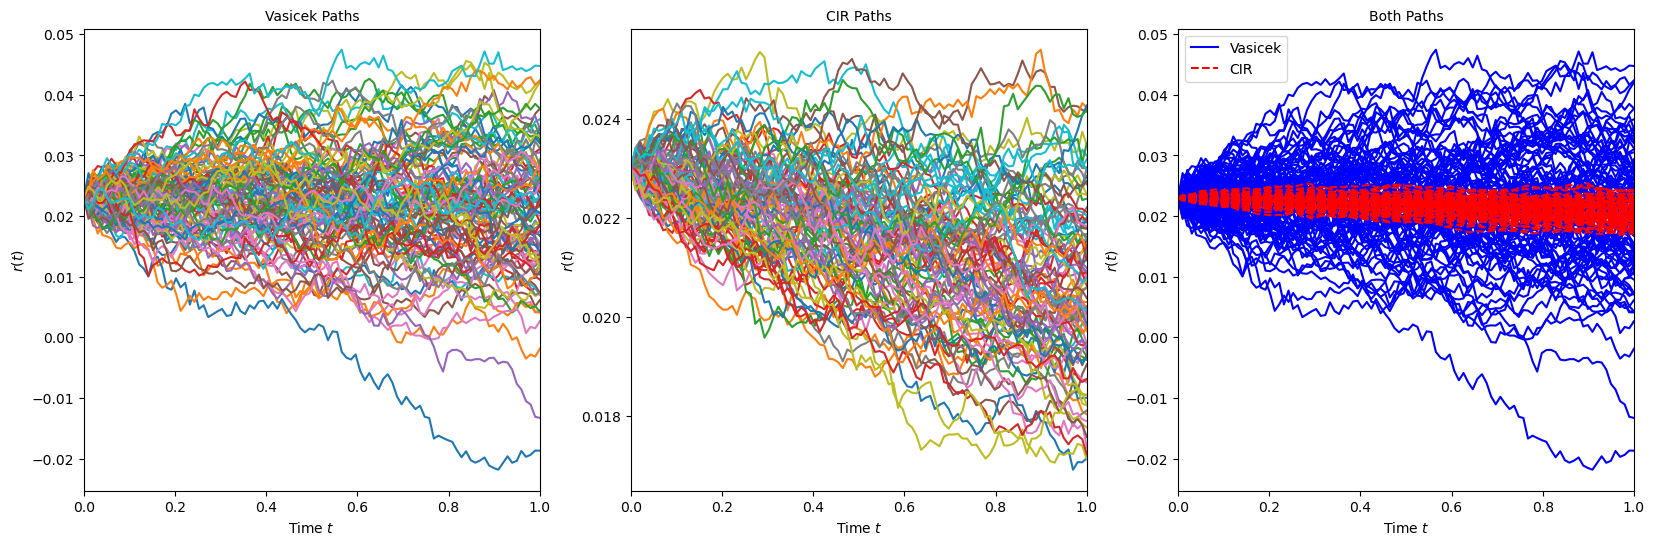

In [5]:
plt.figure(figsize=(20, 6))
plt.subplot(131)
plt.plot(t, rates[:, :])
plt.xlabel("Time $t$", fontsize=10)
plt.ylabel("$r(t)$", fontsize=10)
plt.title("Vasicek Paths", fontsize=10)
axes = plt.gca()
axes.set_xlim([0, T])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.subplot(132)
plt.plot(t, rates_cir[:, :])
plt.xlabel("Time $t$", fontsize=10)
plt.ylabel("$r(t)$", fontsize=10)
plt.title("CIR Paths", fontsize=10)
axes = plt.gca()
axes.set_xlim([0, T])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.subplot(133)
plt.plot(t, rates[:, 1:], "b")
plt.plot(t, rates[:, 0], "b", label="Vasicek")
plt.plot(t, rates_cir[:, 1:], "r--")
plt.plot(t, rates_cir[:, 0], "r--", label="CIR")
plt.legend()
plt.xlabel("Time $t$", fontsize=10)
plt.ylabel("$r(t)$", fontsize=10)
plt.title("Both Paths", fontsize=10)
axes = plt.gca()
axes.set_xlim([0, T])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

_______________

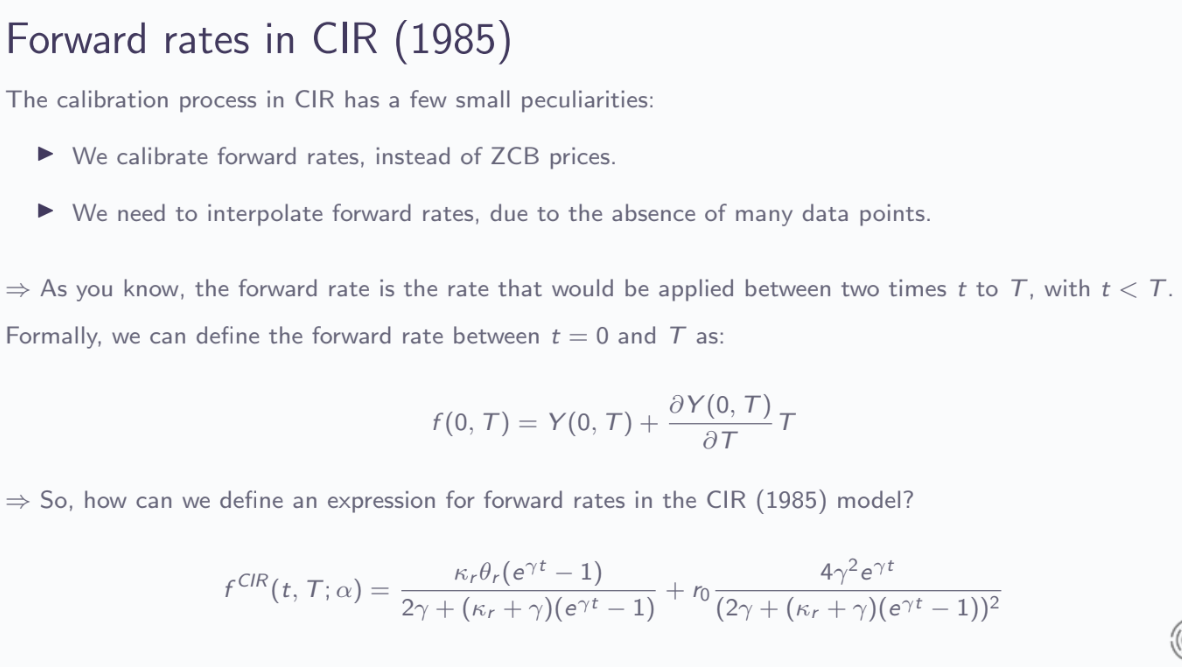

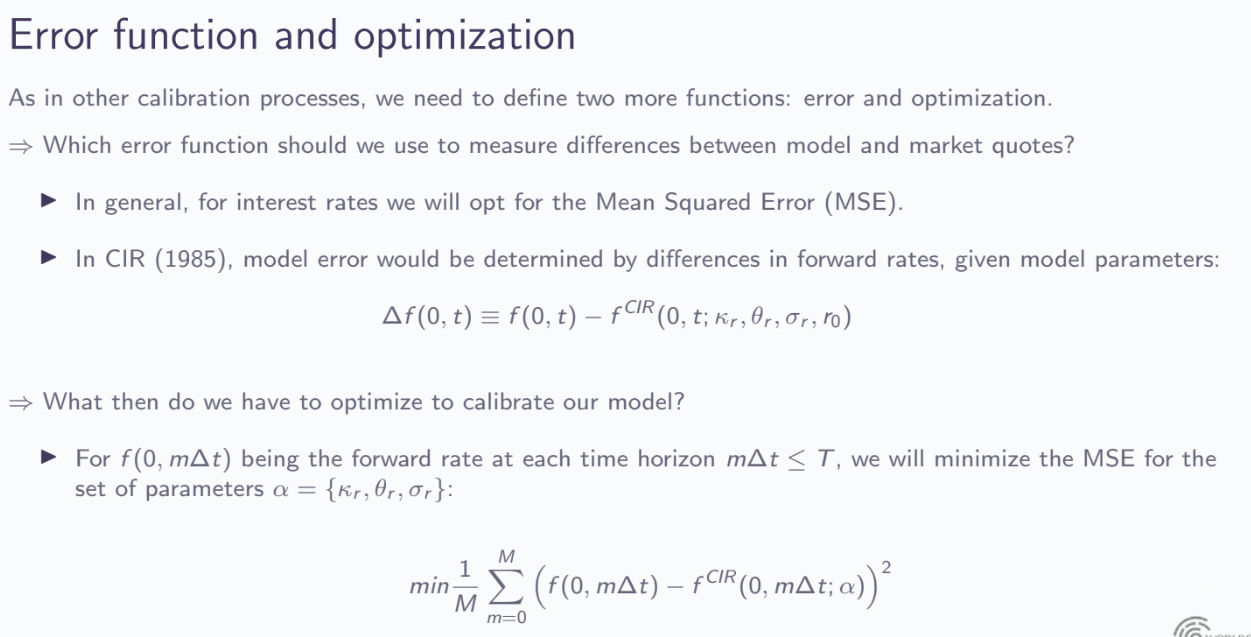

## **1. Steps in the Calibration of Interest Rate Models**

We have been dealing with model calibration for a while now. In general the steps to follow are always the same:

- Get market data
- Build up your valuation function according to your model
- Error function (difference between model output and observed market prices)
- Optimization function (minimizing error function)

Throughout this notebook, we will guide you through these steps in the specific context of the CIR (1985) model. Note, however, that except for the specific bond valuation functions of CIR, the rest can be equally applied to Vasicek (1977) or any other short rate model. 


## **2. Get Bond Market Data**

The first task that we need to complete is to get Zero-Coupon-Bond (ZCB) market data. Now, remember that one of the most important features we need to take into account is risk-neutral valuation. For that reason, we have to look for market data on risk-free ZCBs.

The question of what exactly is a ZCB is not so easy to answer. As a generalization, for the U.S. we would use the Treasury Yield Curve (https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics), even though some of these bonds have an embedded coupon (i.e., they are not all exactly 'zero-coupon').

For the case of Europe, it is not so clear either. Historically, people have most commonly used Euribor (https://www.euribor-rates.eu/en/) or Eonia (currently nonexistent) rates. More recently, the ECB (European Central Bank) and other European agencies are working on providing a new short-term euro risk-free rate reference (https://www.ecb.europa.eu/paym/interest_rate_benchmarks/WG_euro_risk-free_rates/html/index.en.html).

In any case, for the purpose of this calibration we will use Euribor+Eonia rates on Sept, 30th, 2014. Remember we do this because this is the actual data for which we calibrated our options pricing models on EuroStoxx 50. Later on, we will incorporate the interest rate model calibration into an option pricing model for that date.

If we had consulted ECB on Sept. 30th, 2014, we would have obtained Euribor (risk-free) rates for different maturities (in days, divided by 360 to express it as a fraction of years):

In [6]:
mat_list = np.array((1, 7, 14, 30, 60, 90, 180, 270, 360)) / 360
rate_list = (
    np.array((-0.032, -0.013, -0.013, 0.007, 0.043, 0.083, 0.183, 0.251, 0.338)) / 100
)

## **3. Bond Pricing and Forward Rates in the CIR (1985) Model**

Next, we have to build up the valuation of bonds according to the Cox-Ingersoll-Ross model of 1985. 

The CIR model has the following general SDE:
$$
\
\begin{equation*}
  dr_t = k_r(\theta_r-r_t)dt + \sigma_r \sqrt{r_t} dz_t
\end{equation*}
$$
\
In this model, prices of ZCBs paying 1 monetary unit at T take the following form:
$$
\
\begin{equation*}
        B_0(T) = b_1(T) e^{-b_2(T)r_0}
\end{equation*}
$$
\
where
$$
\
\begin{equation*}
        b_1(T) = \left[ \frac{2\gamma e^{((k_r+\gamma)T/2)}}{ 2\gamma + (k_r +  \gamma)(e^{\gamma T}-1) } \right]^{\frac{2k_r\theta_r}{\sigma^2_r}}
\end{equation*}
$$
$$
\
\begin{equation*}
        b_2(T) = \frac{2(e^{\gamma T}-1)}{2\gamma + (k_r + \gamma)(e^{\gamma T}-1)}
\end{equation*}
$$
$$
\
\begin{equation*}
        \gamma = \sqrt{k^2_r + 2\sigma^2_r}
\end{equation*}
$$

### **3.1. Forward Rates and Capitalization Factors**

\
When we perform our calibration, the goal is going to select model parameters ($\kappa_r$, $\theta_r$, $\sigma_r$, $r_0$) so to minimize the differences between the rates produced by the model, and the rates observed in practice. In other words, minimize $\Delta f(0, t)$:

$$
\
\begin{equation*}
    \Delta f(0, t) \equiv f(0, t) - f^{CIR}(0, t; \kappa_r, \theta_r, \sigma_r, r_0)
\end{equation*}
$$
\
where $f(0,t)$ is the current market implied forward rate between $0$ and time $t$. Formally, the forward rate from any time $t$ to $T$ is defined as:
$$
\
\begin{equation*}
   f(t,T) \equiv -\frac{\partial B_t(T)}{\partial T}
\end{equation*}
$$
\
Now, using the previous formula and the expressions we know from the CIR (1985) model, we can define the forward rate between times $t$ and $T$ and a set of parameters $\alpha$ in the following way:
$$
\
\begin{equation*}
   f^{CIR}(t,T; \alpha) = \frac{\kappa_r \theta_r (e^{\gamma t}-1)}{2\gamma + (\kappa_r + \gamma)(e^{\gamma t}-1)} + r_0 \frac{4\gamma^2 e^{\gamma t}}{(2\gamma + (\kappa_r + \gamma)(e^{\gamma t}-1))^2}
\end{equation*}
$$
\
Of course, the fact we are considering forward rates makes a lot of sense; since we are going to be projecting things into the future, we would like to calibrate the model to the actual forward rates implied by the ZCB prices. 

Now, when using forward rates between two different times (e.g., $t$ and $T$), our bond valuation equation would slightly change in notation. You will realize that there are no major changes in the formula but, for the sake of completeness, we include them next (*Note: you can check the derivation of the different equations in, among others, Svoboda (2002), [which is available here](https://www.econbiz.de/Record/interest-rate-model-theory-with-reference-to-the-south-african-market-van-wijck-tjaart/10009442156):
$$
\
\begin{equation*}
        B_t(T) = a(t,T) e^{-b(t,T)\mathbf{E_0^Q}(r_t)}
\end{equation*}
$$
\
where
$$
\
\begin{equation*}
        a(t, T) = \left[ \frac{2\gamma e^{((k_r+\gamma)(T-t)/2)}}{ 2\gamma + (k_r +  \gamma)(e^{\gamma (T-t)}-1) } \right]^{\frac{2k_r\theta_r}{\sigma^2_r}}
\end{equation*}
$$
$$
\
\begin{equation*}
        b(t, T) = \frac{2(e^{\gamma (T-t)}-1)}{2\gamma + (k_r + \gamma)(e^{\gamma (T-t)}-1)}
\end{equation*}
$$
\
with 
$$
\
\begin{equation*}
    \mathbf{E_0^Q}(r_t) = \theta_r + e^{-\kappa_r t}(r_0- \theta_r)
\end{equation*}
$$
\
and, of course, still with $\gamma = \sqrt{k^2_r + 2\sigma^2_r}$.

\
Unfortunately, we do not typically get market quotes of the forward rates, which is what we need to properly execute our model calibration via minimizing $\Delta f(t,T)$ above for different $t$. Instead, we just have the yields (or rates) for different ZCBs and their maturities.

Luckily for us, there is a very simple way of going from bond yields to forward rates and vice versa (this, you should be familiar with even before the course). Suppose $Y(0, T)$ is the current bond yield (short rate) of a ZCB that pays 1 unit at maturity $T$:
$$
\
\begin{equation*}
    f(0, T) = Y(0, T) + \frac{\partial Y(0, T)}{\partial T}T
\end{equation*}
$$
\
Simultaneously, we know that the price of that bond today, given yield $Y(0, T)$ should solve the following equation:
$$
\
\begin{equation*}
    B_T(T) = B_0(T) e^{Y(0,T) T} \Leftrightarrow Y(0,T) = \frac{log B_T(T) - log B_0(T)}{T}
\end{equation*}
$$
\
and since we have normalized the face value of the bond at maturity to 1:
$$
\
\begin{equation*}
    Y(0,T) = -\frac{log B_0(T)}{T}
\end{equation*}
$$
\
Similarly, we can derive capitalization factors (the continuous yield of a unit ZCB) and equivalent annualized continuous rates. For example, capitalization factor, $f_s^{3m}$, for the 3 months Euribor rate, $Eur_{3m}$ would be:
$$
\
\begin{equation*}
    f_s^{3m} = 1 + 90/360 \times Eur_{3m}
\end{equation*}
$$
\
The equivalent annualized continuous rate, $f_c^{3m}$, is therefore defined as:
$$
\
\begin{equation*}
    f_c^{3m} = 360/90 \times log(f_s^{3m})
\end{equation*}
$$
\
which ensures the following relationship is satisfied:
$$
\
\begin{equation*}
    1 + 90/360 \times f_s^{3m} = e^{90/360 f^{3m}_c}
\end{equation*}
$$
\
So, now that we know all this, let's define the current short-term rate ($r_0$), the capitalization factors and the zero-forward rates implied by the Euribor rates observed in the market. (*Note that we are using 30/360 convention for the rates since this is the way Euribor--and most rates--are quoted*)

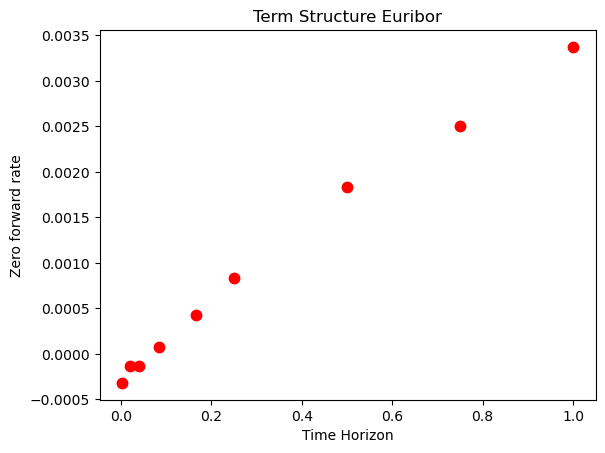

In [8]:
r0 = rate_list[0]
factors = 1 + mat_list * rate_list
zero_rates = 1 / mat_list * np.log(factors)

plt.plot(mat_list, zero_rates, "r.", markersize="15")
plt.xlabel("Time Horizon")
plt.ylabel("Zero forward rate")
plt.title("Term Structure Euribor")
plt.show()

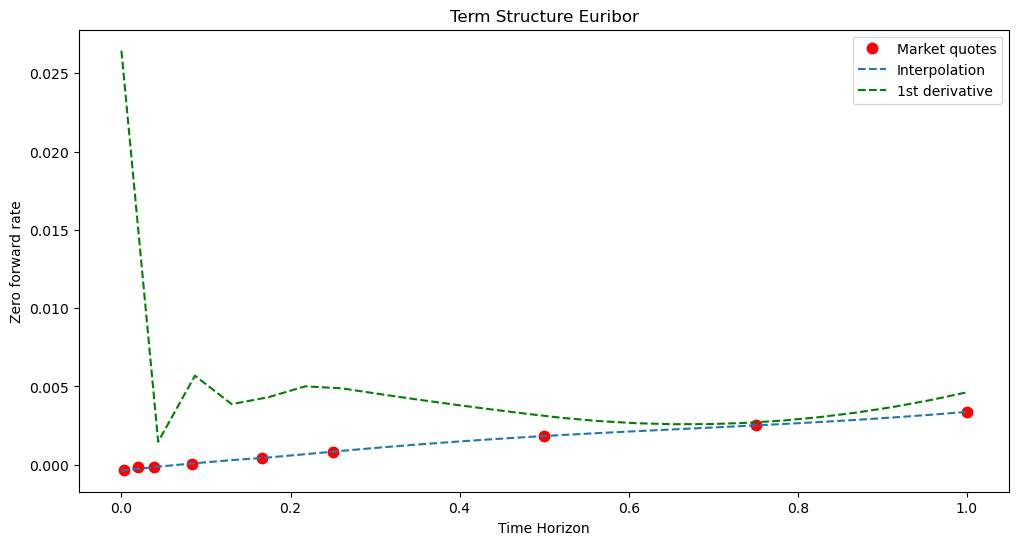

In [9]:
from scipy.interpolate import splev, splrep

bspline = splrep(mat_list, zero_rates, k=3)  # Cubic spline
mat_list_n = np.linspace(
    0.0, 1.0, 24
)  # Create 24 equally spaced maturities between 0 and 1
inter_rates = splev(mat_list_n, bspline, der=0)  # Interpolated rates

first_der = splev(mat_list_n, bspline, der=1)  # First derivative of spline
f = (
    inter_rates + first_der * mat_list_n
)  # Forward rate given interpolated ones and first derivative

plt.figure(figsize=(12, 6))
plt.plot(mat_list, zero_rates, "r.", markersize="15", label="Market quotes")
plt.plot(mat_list_n, inter_rates, "--", markersize="10", label="Interpolation")
plt.plot(mat_list_n, first_der, "g--", markersize="10", label="1st derivative")
plt.xlabel("Time Horizon")
plt.ylabel("Zero forward rate")
plt.title("Term Structure Euribor")
plt.legend()
plt.show()

As you can see, we do not perfectly match the observed market data, but we are pretty close. In turn, we have many more data points that we can use to calibrate our interest rate model to observed (or, better said, interpolated from observed) market quotes.

Finally, before jumping to the pure calibration, let's define one last function. We will calibrate forward rates of the CIR (1985) model. Hence, let's define in Python the forward rate expression in the CIR model, $f^{CIR}(t,T; \alpha)$. Remember that we have already seen this expression before:
$$
\
\begin{equation*}
   f^{CIR}(t,T; \alpha) = \frac{\kappa_r \theta_r (e^{\gamma t}-1)}{2\gamma + (\kappa_r + \gamma)(e^{\gamma t}-1)} + r_0 \frac{4\gamma^2 e^{\gamma t}}{(2\gamma + (\kappa_r + \gamma)(e^{\gamma t}-1))^2}
\end{equation*}
$$


In [10]:
from scipy.optimize import fmin

def CIR_forward_rate(alpha):
    """
    Forward rates in CIR (1985) model
    The set of parameters is called alpha and include Kappa_r, Theta_r and Sigma_r
    """

    kappa_r, theta_r, sigma_r = alpha

    t = mat_list_n
    g = np.sqrt(kappa_r**2 + 2 * sigma_r**2)

    s1 = (kappa_r * theta_r * (np.exp(g * t) - 1)) / (
        2 * g + (kappa_r + g) * (np.exp(g * t) - 1)
    )

    s2 = r0 * (
        (4 * g**2 * np.exp(g * t)) / (2 * g + (kappa_r + g) * (np.exp(g * t)) ** 2)
    )

    return s1 + s2

def CIR_error_function(alpha):
    """
    Error function to calibrate CIR (1985) model
    """

    kappa_r, theta_r, sigma_r = alpha

    # Few remarks to avoid problems for certain values of parameters:
    if 2 * kappa_r * theta_r < sigma_r**2:
        return 100
    if kappa_r < 0 or theta_r < 0 or sigma_r < 0.001:
        return 100

    forward_rates = CIR_forward_rate(alpha)
    MSE = np.sum((f - forward_rates) ** 2) / len(f)

    return MSE

def CIR_calibration():
    opt = fmin(
        CIR_error_function,
        [1.0, 0.02, 0.1],
        xtol=0.00001,
        ftol=0.00001,
        maxiter=300,
        maxfun=500,
    )

    return opt

params = CIR_calibration()
params

C:\Users\Atakan\AppData\Local\Temp\ipykernel_12532\557309505.py:43: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  opt = fmin(


array([0.06831325, 0.20771701, 0.11263583])

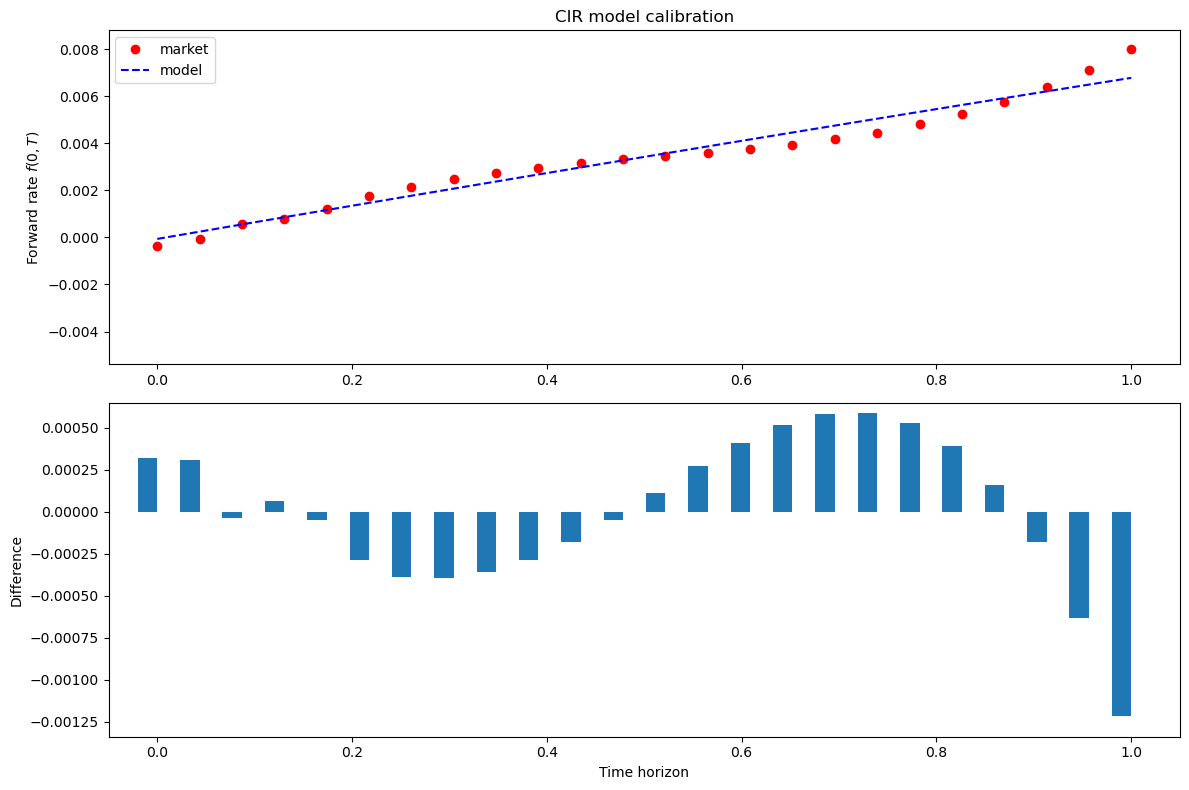

In [12]:
def plot_calibrated_frc(opt):
    """Plots market and calibrated forward rate curves."""
    forward_rates = CIR_forward_rate(opt)
    plt.figure(figsize=(12, 8))
    plt.subplot(211)
    plt.title("CIR model calibration")
    plt.ylabel("Forward rate $f(0,T)$")
    plt.plot(mat_list_n, f, "ro", label="market")
    plt.plot(mat_list_n, forward_rates, "b--", label="model")
    plt.legend(loc=0)
    plt.axis(
        [min(mat_list_n) - 0.05, max(mat_list_n) + 0.05, min(f) - 0.005, max(f) * 1.1]
    )
    plt.subplot(212)
    wi = 0.02
    plt.bar(mat_list_n - wi / 2, forward_rates - f, width=wi)
    plt.xlabel("Time horizon")
    plt.ylabel("Difference")
    plt.axis(
        [
            min(mat_list_n) - 0.05,
            max(mat_list_n) + 0.05,
            min(forward_rates - f) * 1.1,
            max(forward_rates - f) * 1.1,
        ]
    )
    plt.tight_layout()

plot_calibrated_frc(params)

__________________

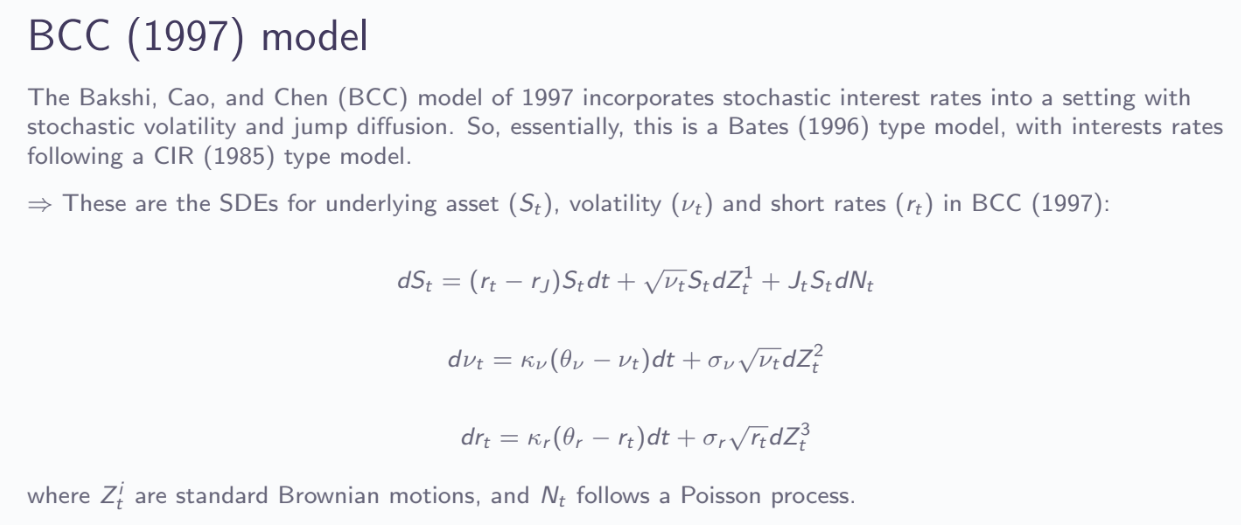

## **1. BCC (1997) Model**

The Bakshi, Cao, and Chen (BCC) model of 1997 incorporates three very relevant features to model underlying asset prices:

- Stochastic volatility (Heston, 1993)
- Jump diffusion (Merton, 1976)
- Stochastic interests rates (Cox-Ingersoll-Ross, 1985)

At  this point, you already know models such as Bates (1996) that incorporate the first two characteristics on the list. Therefore, the transition to BCC (1997) model should be pretty smooth, as it basically only adds a change in the way to set the short-rate as any point $t$.

The set of SDEs that BCC (1997) relies on is the following:
$$
\
\begin{equation}
    dS_t = (r_t - r_J) S_t dt + \sqrt{\nu_t} S_t dZ_t^1 + J_t S_t dN_t
\end{equation}
$$
$$
\
\begin{equation} 
    d\nu_t = \kappa_\nu (\theta_\nu - \nu_t)dt + \sigma_\nu \sqrt{\nu_t}dZ_t^2
\end{equation}
$$
$$
\
\begin{equation} 
    dr_t = \kappa_r (\theta_r - r_t)dt + \sigma_r \sqrt{r_t}dZ_t^3
\end{equation}
$$
\
where $Z_t^i$ are standard Brownian motions, and $N_t$ follows a Poisson process.

As we mentioned before, the first 2 equations are equivalent to a Bates (1996) model with exogenous short rate, $r_t$. Hence, let's start by recoding this model, so that later on we can compare it to the BCC (1997) estimates.

## **1.1. Revisiting Bates (1996)**

For the purpose of later comparison of Bates (1996) versus BCC (1997) models, we include here the code for Bates that we saw in the previous module:

In [13]:
import numpy as np
from scipy.integrate import quad

# Call Value function
def B96_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Valuation of European call option in B96 Model via Lewis (2001)
    Parameters:
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial level of variance
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    ==========
    """
    int_value = quad(
        lambda u: B96_int_func(
            u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
        ),
        0,
        np.inf,
        limit=250,
    )[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value

# Heston (1993) characteristic function
def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)
    Fourier-based approach: characteristic function.
    Parameter definitions see function BCC_call_value."""
    c1 = kappa_v * theta_v
    c2 = -np.sqrt(
        (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
    )
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
        kappa_v - rho * sigma_v * u * 1j - c2
    )
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = (
        (kappa_v - rho * sigma_v * u * 1j + c2)
        / sigma_v**2
        * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    )
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

# Merton (1976) characteristic function
def M76J_char_func(u, T, lamb, mu, delta):
    """
    Adjusted Characteristic function for Merton '76 model: Only jump component
    """

    omega = -lamb * (np.exp(mu + 0.5 * delta**2) - 1)
    char_func_value = np.exp(
        (1j * u * omega + lamb * (np.exp(1j * u * mu - u**2 * delta**2 * 0.5) - 1))
        * T
    )
    return char_func_value

# Bates (1996) characteristic function (H93+M76)
def B96_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Bates (1996) characteristic function
    """
    H93 = H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    M76J = M76J_char_func(u, T, lamb, mu, delta)
    return H93 * M76J

# Lewis (2001) integral value of Bates (1996)
def B96_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Lewis (2001) integral value for Bates (1996) characteristic function
    """
    char_func_value = B96_char_func(
        u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
    )
    int_func_value = (
        1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    )
    return int_func_value

# BCC (1997) characteristic function (H93+M76)
def BCC_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    BCC (1997) characteristic function
    """
    H93 = H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    M76J = M76J_char_func(u, T, lamb, mu, delta)
    return H93 * M76J

# Lewis (2001) integral value of BCC (1997)
def BCC_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Lewis (2001) integral value for BCC (1997) characteristic function
    """
    char_func_value = BCC_char_func(
        u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
    )
    int_func_value = (
        1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    )
    return int_func_value

# Call Value function
def BCC_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Valuation of European call option in B96 Model via Lewis (2001)
    Parameters:
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial level of variance
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    ==========
    """
    int_value = quad(
        lambda u: BCC_int_func(
            u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
        ),
        0,
        np.inf,
        limit=250,
    )[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value

def gamma(kappa_r, sigma_r):
    """
    Gamma function in CIR (1985)
    """
    return np.sqrt(kappa_r**2 + 2 * sigma_r**2)

def b1(alpha):
    """
    b1 function in CIR (1985)
    alpha is the parameter set
    """
    r0, kappa_r, theta_r, sigma_r, t, T = alpha
    g = gamma(kappa_r, sigma_r)
    x = (
        (2 * g * np.exp((kappa_r + g) * (T - t) / 2))
        / (2 * g + (kappa_r + g) * (np.exp(g * (T - t)) - 1))
    ) ** (2 * kappa_r * theta_r / sigma_r**2)

    return x

def b2(alpha):
    """
    b2 function in CIR (1985)
    alpha is the parameter set
    """
    r0, kappa_r, theta_r, sigma_r, t, T = alpha
    g = gamma(kappa_r, sigma_r)
    x = (2 * (np.exp(g * (T - t)) - 1)) / (
        2 * g + (kappa_r + g) * (np.exp(g * (T - t)) - 1)
    )

    return x

def B(alpha):
    """
    ZCB prices in the CIR (1985) model
    """
    b_1 = b1(alpha)
    b_2 = b2(alpha)
    r0, kappa_r, theta_r, sigma_r, t, T = alpha

    E_rt = theta_r + np.exp(-kappa_r * t) * (r0 - theta_r)

    zcb = b_1 * np.exp(-b_2 * E_rt)

    return zcb

In [14]:
# Short-rates
r0 = -0.032 / 100
kappa_r = 0.068
theta_r = 0.207
sigma_r = 0.112

# SV
kappa_v = 18.447
theta_v = 0.026
sigma_v = 0.978
rho = -0.821
v0 = 0.035

# JD
lamb = 0.008
mu = -0.600
delta = 0.001

B96_call = B96_call_value(
    100, 90, 1, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
)
print("Call value under Bates (1996): ", B96_call)

Call value under Bates (1996):  12.815339205009337


In [15]:
B0T = B([r0, kappa_r, theta_r, sigma_r, 0, 1])
r = -np.log(B0T) / 1

BCC_call = BCC_call_value(
    100, 90, 1, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
)
print("Call value under BCC (1997): ", BCC_call)

Call value under BCC (1997):  13.277735226230888


____________

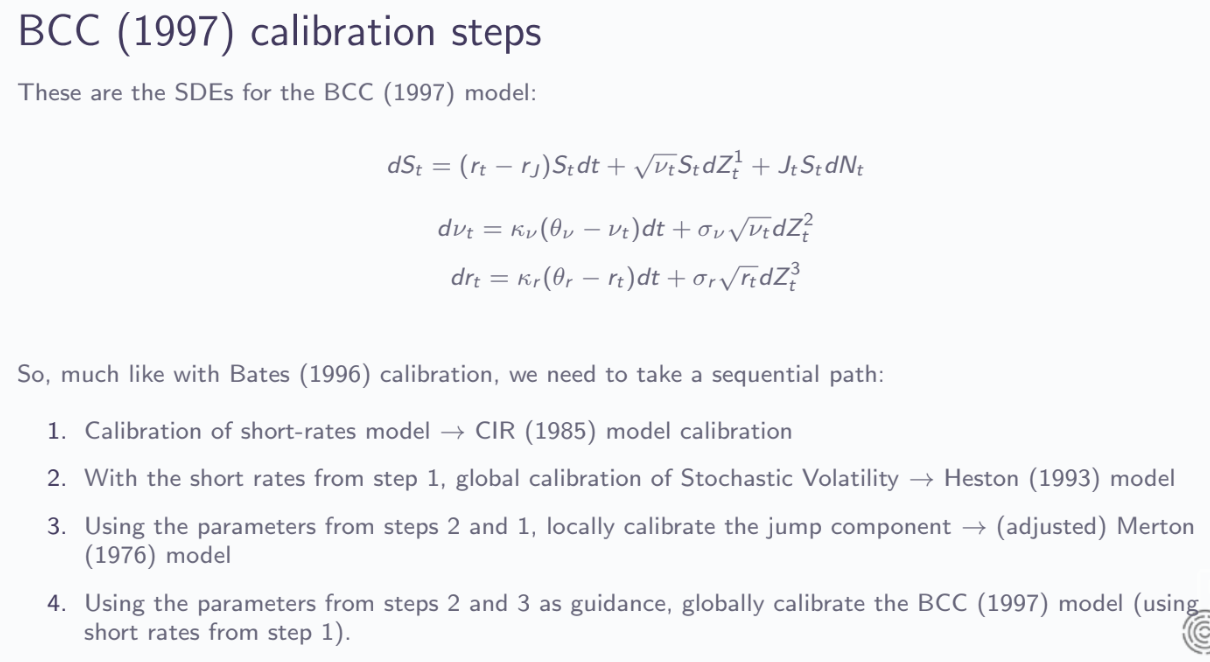

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy.interpolate import splev, splrep
from scipy.optimize import brute, fmin

As is always the case when we have a model with distinct components that have to be calibrated to market data simultaneously, we have to start by following a sequential order. There are four general steps involved in the calibration of a BCC model:

1. Calibration of short interest rates
2. Calibration of stochastic volatility component of underlying asset
3. Calibration of jump component of underlying asset
4. Full calibration with the previous parameters from 2 and 3 as guidance


Note that we are indeed establishing a clear separation between the calibration of the interest rates and the rest of the BCC model components. This is due to the assumption that the underlying asset and interest rates have zero correlation between each other. 

For simplicity, we will use the same data we have been dealing with in previous model calibrations. But remember that we can do this for any dataset with market information on interest rates and underlying asset prices.

## **1. Calibration of Short Rates**

First, we will calibrate the short rate model in BCC, which is essentially the CIR (1985) model we calibrated in Lesson 2 of this very same module. For the sake of completeness, we reproduce the process here. Please go back to the Lesson 2 notebook for more detailed information on the process.

In [17]:
# Euribor Market data
mat_list = np.array((1, 7, 14, 30, 60, 90, 180, 270, 360)) / 360
rate_list = (
    np.array((-0.032, -0.013, -0.013, 0.007, 0.043, 0.083, 0.183, 0.251, 0.338)) / 100
)

# Capitalization factors and Zero-rates
r0 = rate_list[0]
factors = 1 + mat_list * rate_list
zero_rates = 1 / mat_list * np.log(factors)

# Interpolation and Forward rates
bspline = splrep(mat_list, zero_rates, k=3)  # Cubic spline
mat_list_n = np.linspace(
    0.0, 1.0, 24
)  # Create 24 equally spaced maturities between 0 and 1
inter_rates = splev(mat_list_n, bspline, der=0)  # Interpolated rates

first_der = splev(mat_list_n, bspline, der=1)  # First derivative of spline
f = (
    inter_rates + first_der * mat_list_n
)  # Forward rate given interpolated ones and first derivative

# CIR (1985) Forward rate function
def CIR_forward_rate(alpha):
    """
    Forward rates in CIR (1985) model
    The set of parameters is called alpha and include Kappa_r, Theta_r and Sigma_r
    """

    kappa_r, theta_r, sigma_r = alpha

    t = mat_list_n
    g = np.sqrt(kappa_r**2 + 2 * sigma_r**2)

    s1 = (kappa_r * theta_r * (np.exp(g * t) - 1)) / (
        2 * g + (kappa_r + g) * (np.exp(g * t) - 1)
    )

    s2 = r0 * (
        (4 * g**2 * np.exp(g * t)) / (2 * g + (kappa_r + g) * (np.exp(g * t)) ** 2)
    )

    return s1 + s2

# CIR (1985) Error function
def CIR_error_function(alpha):
    """
    Error function to calibrate CIR (1985) model
    """

    kappa_r, theta_r, sigma_r = alpha

    # Few remarks to avoid problems for certain values of parameters:
    if 2 * kappa_r * theta_r < sigma_r**2:
        return 100
    if kappa_r < 0 or theta_r < 0 or sigma_r < 0.001:
        return 100

    forward_rates = CIR_forward_rate(alpha)
    MSE = np.sum((f - forward_rates) ** 2) / len(f)

    return MSE

# CIR (1985) Calibration via minimizing Forward rate differences
def CIR_calibration():
    opt = fmin(
        CIR_error_function,
        [1.0, 0.02, 0.1],
        xtol=0.00001,
        ftol=0.00001,
        maxiter=300,
        maxfun=500,
    )

    return opt

In [20]:
params_CIR = CIR_calibration()
# CIR (1985) calibrated parameters
kappa_r, theta_r, sigma_r = params_CIR
params_CIR

C:\Users\Atakan\AppData\Local\Temp\ipykernel_12532\347498513.py:67: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  opt = fmin(


array([0.06831325, 0.20771701, 0.11263583])

## **2. Calibration of Stochastic Volatility Component (Heston, 1993)**

Next, we will take the calibrated CIR model parameters as inputs and essentially perform a calibration process similar to the one we implemented for the Bates (1996) model. Once again, we will focus on the same market data (i.e., options on EuroStoxx 50), so the calibration process should be pretty similar to the one we performed in previous modules. Please refer to these modules for further explanation of specific steps if needed.

## **2.1. Load Market Data**

The first step is to load options market data to be used in the calibration:

In [25]:
# Option market data loading
h5 = pd.HDFStore("option_data_M3.h5", "r")
data = h5["data"]  # European call & put option data (3 maturities)
h5.close()
S0 = 3225.93  # EURO STOXX 50 level 30.09.2014

# Selection of options for calibration
tol = 0.02  # percent ITM/OTM options
options = data[(np.abs(data["Strike"] - S0) / S0) < tol]
options["Date"] = pd.DatetimeIndex(options["Date"])
options["Maturity"] = pd.DatetimeIndex(options["Maturity"])

mats = sorted(set(options["Maturity"]))
options = options[options["Maturity"] == mats[0]]

# ZCB pricing functions under CIR (1985)


def gamma(kappa_r, sigma_r):
    """
    Gamma function in CIR (1985)
    """
    return np.sqrt(kappa_r**2 + 2 * sigma_r**2)


def b1(alpha):
    """
    b1 function in CIR (1985)
    alpha is the parameter set
    """
    r0, kappa_r, theta_r, sigma_r, t, T = alpha
    g = gamma(kappa_r, sigma_r)
    x = (
        (2 * g * np.exp((kappa_r + g) * (T - t) / 2))
        / (2 * g + (kappa_r + g) * (np.exp(g * (T - t)) - 1))
    ) ** (2 * kappa_r * theta_r / sigma_r**2)

    return x


def b2(alpha):
    """
    b2 function in CIR (1985)
    alpha is the parameter set
    """
    r0, kappa_r, theta_r, sigma_r, t, T = alpha
    g = gamma(kappa_r, sigma_r)
    x = (2 * (np.exp(g * (T - t)) - 1)) / (
        2 * g + (kappa_r + g) * (np.exp(g * (T - t)) - 1)
    )

    return x


def B(alpha):
    """
    ZCB prices in the CIR (1985) model
    """
    b_1 = b1(alpha)
    b_2 = b2(alpha)
    r0, kappa_r, theta_r, sigma_r, t, T = alpha

    E_rt = theta_r + np.exp(-kappa_r * t) * (r0 - theta_r)

    zcb = b_1 * np.exp(-b_2 * E_rt)

    return zcb

# Including short rates and time to maturity
for row, option in options.iterrows():
    T = (option["Maturity"] - option["Date"]).days / 365.0
    options.loc[row, "T"] = T
    B0T = B([r0, kappa_r, theta_r, sigma_r, 0, T])
    options.loc[row, "r"] = -np.log(B0T) / T

i = 0
min_MSE = 500

def H93_error_function(p0):
    """Error function for parameter calibration via
    Lewis (2001) Fourier approach for Heston (1993).
    Parameters
    ==========
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial, instantaneous variance
    Returns
    =======
    MSE: float
        mean squared error
    """
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0:
        return 500.0
    if 2 * kappa_v * theta_v < sigma_v**2:
        return 500.0
    se = []
    for row, option in options.iterrows():
        model_value = H93_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
        )
        se.append((model_value - option["Call"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 100 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

def H93_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)

    Parameter definition:
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial level of variance
    Returns
    =======
    call_value: float
        present value of European call option
    """
    int_value = quad(
        lambda u: H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0),
        0,
        np.inf,
        limit=250,
    )[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value

def H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """
    Fourier-based approach for Lewis (2001): Integration function.
    """
    char_func_value = H93_char_func(
        u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0
    )
    int_func_value = (
        1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    )
    return int_func_value

def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)
    Fourier-based approach: characteristic function.
    Parameter definitions see function BCC_call_value."""
    c1 = kappa_v * theta_v
    c2 = -np.sqrt(
        (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
    )
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
        kappa_v - rho * sigma_v * u * 1j - c2
    )
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = (
        (kappa_v - rho * sigma_v * u * 1j + c2)
        / sigma_v**2
        * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    )
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

def H93_calibration_full():
    """Calibrates Heston (1993) stochastic volatility model to market quotes."""
    # First run with brute force
    # (scan sensible regions, for faster convergence)
    p0 = brute(
        H93_error_function,
        (
            (2.5, 10.6, 5.0),  # kappa_v
            (0.01, 0.041, 0.01),  # theta_v
            (0.05, 0.251, 0.1),  # sigma_v
            (-0.75, 0.01, 0.25),  # rho
            (0.01, 0.031, 0.01),
        ),  # v0
        finish=None,
    )

    # Second run with local, convex minimization
    # (we dig deeper where promising results)
    opt = fmin(
        H93_error_function, p0, xtol=0.000001, ftol=0.000001, maxiter=950, maxfun=900
    )
    return opt

C:\Users\Atakan\AppData\Local\Temp\ipykernel_12532\1987439521.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options["Date"] = pd.DatetimeIndex(options["Date"])
C:\Users\Atakan\AppData\Local\Temp\ipykernel_12532\1987439521.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options["Maturity"] = pd.DatetimeIndex(options["Maturity"])


In [26]:
kappa_v, theta_v, sigma_v, rho, v0 = H93_calibration_full()

   0 | [ 2.5   0.01  0.05 -0.75  0.01] | 366.955 | 366.955
 100 | [ 2.5   0.04  0.05 -0.5   0.02] |  63.926 |   6.589
 200 | [ 7.5   0.02  0.25 -0.25  0.03] |  11.119 |   6.589
 300 | [ 1.678065    0.03263888  0.30623977 -0.9250553   0.03049744] |   4.802 |   4.627
 400 | [ 1.48034684  0.03519223  0.3190103  -0.99986661  0.03029015] |   4.163 |   4.162
 500 | [ 1.32002332  0.07534462  0.44593412 -0.99165255  0.03023096] |   2.985 |   2.985
 600 | [ 1.1826757   0.10177896  0.49064827 -0.9872959   0.02916145] |   2.069 |   2.069
 700 | [ 1.23041469  0.11511016  0.53222589 -0.98440602  0.02906222] |   1.797 |   1.797
 800 | [ 1.22834306  0.11782459  0.53801295 -0.98390762  0.02896912] |   1.725 |   1.725
 900 | [ 1.23231343  0.11886808  0.54126283 -0.98368121  0.02896045] |   1.708 |   1.707


C:\Users\Atakan\AppData\Local\Temp\ipykernel_12532\1987439521.py:216: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  opt = fmin(


## **3. Calibration of the Jump Component**

Next, we will use these parameter values to calibrate the jump component of BCC (1997). Once again, this process is very similar to that of Bates (1996) calibration, so we will omit a deep explanation of the specific steps.

\
Let's start with our error function and the calibration of jump parameters according to the previous stochastic volatility parameter values:

In [27]:
i = 0
min_MSE = 5000.0
local_opt = False

def BCC_error_function_v1(p0):
    """
    Error function for BCC (1997) model
    """
    global i, min_MSE, local_opt, opt1
    lamb, mu, delta = p0
    if lamb < 0.0 or mu < -0.6 or mu > 0.0 or delta < 0.0:
        return 5000.0
    se = []
    for row, option in options.iterrows():
        model_value = BCC_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        se.append((model_value - option["Call"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 100 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    if local_opt:
        penalty = np.sqrt(np.sum((p0 - opt1) ** 2)) * 1
        return MSE + penalty
    return MSE

# Call Value function
def BCC_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Valuation of European call option in B96 Model via Lewis (2001)
    Parameters:
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial level of variance
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    ==========
    """
    int_value = quad(
        lambda u: BCC_int_func(
            u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
        ),
        0,
        np.inf,
        limit=250,
    )[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value

# BCC (1997) characteristic function (H93+M76)
def BCC_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    BCC (1997) characteristic function
    """
    H93 = H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    M76J = M76J_char_func(u, T, lamb, mu, delta)
    return H93 * M76J


# Merton (1976) characteristic function
def M76J_char_func(u, T, lamb, mu, delta):
    """
    Adjusted Characteristic function for Merton '76 model: Only jump component
    """

    omega = -lamb * (np.exp(mu + 0.5 * delta**2) - 1)
    char_func_value = np.exp(
        (1j * u * omega + lamb * (np.exp(1j * u * mu - u**2 * delta**2 * 0.5) - 1))
        * T
    )
    return char_func_value

# Lewis (2001) integral value of BCC (1997)
def BCC_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Lewis (2001) integral value for BCC (1997) characteristic function
    """
    char_func_value = BCC_char_func(
        u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
    )
    int_func_value = (
        1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    )
    return int_func_value

def BCC_calibration_short():
    """Calibrates jump component of BCC97 model to market quotes."""
    # We first run with brute force
    # (scan sensible regions)
    opt1 = 0.0
    opt1 = brute(
        BCC_error_function_v1,
        (
            (0.0, 0.51, 0.1),  # lambda
            (-0.5, -0.11, 0.1),  # mu
            (0.0, 0.51, 0.25),
        ),  # delta
        finish=None,
    )

    # second run with local, convex minimization
    # (dig deeper where promising)
    opt2 = fmin(
        BCC_error_function_v1,
        opt1,
        xtol=0.0000001,
        ftol=0.0000001,
        maxiter=550,
        maxfun=750,
    )
    return opt2

In [28]:
lamb, mu, delta = BCC_calibration_short()
p0 = [lamb, mu, delta]

   0 | [ 0.  -0.5  0. ] |   1.706 |   1.706
 100 | [ 7.45058060e-12 -5.08333333e-01  8.33333308e-05] |   1.706 |   1.706
 200 | [ 5.84988872e-14 -5.00767061e-01  1.14378617e-04] |   1.706 |   1.706
Optimization terminated successfully.
         Current function value: 1.706173
         Iterations: 62
         Function evaluations: 177


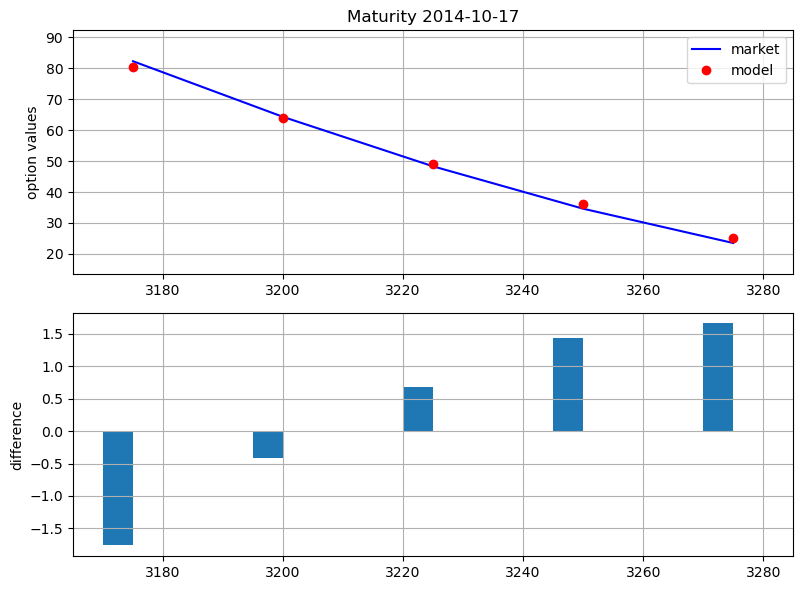

In [29]:
def BCC_jump_calculate_model_values(p0):
    """Calculates all model values given parameter vector p0."""
    lamb, mu, delta = p0
    values = []
    for row, option in options.iterrows():
        model_value = BCC_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        values.append(model_value)
    return np.array(values)

def plot_BCC(p0):
    options["Model"] = BCC_jump_calculate_model_values(p0)
    plt.figure(figsize=(8, 6))
    plt.subplot(211)
    plt.grid()
    plt.title("Maturity %s" % str(options["Maturity"].iloc[0])[:10])
    plt.ylabel("option values")
    plt.plot(options.Strike, options.Call, "b", label="market")
    plt.plot(options.Strike, options.Model, "ro", label="model")
    plt.legend(loc=0)
    plt.axis(
        [
            min(options.Strike) - 10,
            max(options.Strike) + 10,
            min(options.Call) - 10,
            max(options.Call) + 10,
        ]
    )
    plt.subplot(212)
    plt.grid()
    wi = 5.0
    diffs = options.Model.values - options.Call.values
    plt.bar(options.Strike.values - wi / 2, diffs, width=wi)
    plt.ylabel("difference")
    plt.axis(
        [
            min(options.Strike) - 10,
            max(options.Strike) + 10,
            min(diffs) * 1.1,
            max(diffs) * 1.1,
        ]
    )
    plt.tight_layout()

plot_BCC(p0)

## **4. Full BCC Calibration**

Now that we have some guidelines on the magnitude of the model parameters, we can perform a full calibration of the model to increase its fit with market data that simultaneously works on the stochastic volatility and the jump components:

In [31]:
p0 = [kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta]

i = 0
min_MSE = 5000


def BCC_error_function(p0):
    """
    Error function for full parameter calibration of BCC model
    """
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0
    if (
        kappa_v < 0.0
        or theta_v < 0.005
        or sigma_v < 0.0
        or rho < -1.0
        or rho > 1.0
        or v0 < 0.0
        or lamb < 0.0
        or mu < -0.6
        or mu > 0.0
        or delta < 0.0
    ):
        return 5000.0
    if 2 * kappa_v * theta_v < sigma_v**2:
        return 5000.0
    se = []
    for row, option in options.iterrows():
        model_value = BCC_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        se.append((model_value - option["Call"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 100 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

def BCC_calibration_full():
    """
    Full calibration of BCC (1997)
    """
    # local, convex minimization for all parameters
    opt = fmin(
        BCC_error_function, p0, xtol=0.000001, ftol=0.000001, maxiter=450, maxfun=750
    )
    return opt

In [32]:
params_BCC = BCC_calibration_full()
kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = params_BCC

   0 | [ 1.23141678e+00  1.18860837e-01  5.41049397e-01 -9.83689241e-01
  2.89553835e-02  5.84987658e-14 -5.00766842e-01  1.14378525e-04] |   1.706 |   1.706
 100 | [ 1.23349977e+00  1.19118788e-01  5.40574594e-01 -9.98688950e-01
  2.84997495e-02  5.46805051e-14 -5.25667846e-01  1.26311038e-04] |   1.496 |   1.496
 200 | [ 1.22920301e+00  1.19126126e-01  5.41129934e-01 -9.99934996e-01
  2.84120152e-02  5.26462110e-14 -5.33290588e-01  1.31231547e-04] |   1.482 |   1.482
 300 | [ 1.22942439e+00  1.19197701e-01  5.41317775e-01 -9.99872466e-01
  2.84363340e-02  5.32186056e-14 -5.36086627e-01  1.29198776e-04] |   1.480 |   1.480
 400 | [ 1.22890292e+00  1.20149945e-01  5.43345346e-01 -9.99362037e-01
  2.85311806e-02  5.52592541e-14 -5.75392885e-01  1.17125138e-04] |   1.472 |   1.472
 500 | [ 1.22875293e+00  1.20454397e-01  5.43970579e-01 -9.99277014e-01
  2.85536595e-02  5.58153325e-14 -5.87684085e-01  1.13556530e-04] |   1.472 |   1.472
 600 | [ 1.22887570e+00  1.20630621e-01  5.44304333e

C:\Users\Atakan\AppData\Local\Temp\ipykernel_12532\1518046006.py:57: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  opt = fmin(


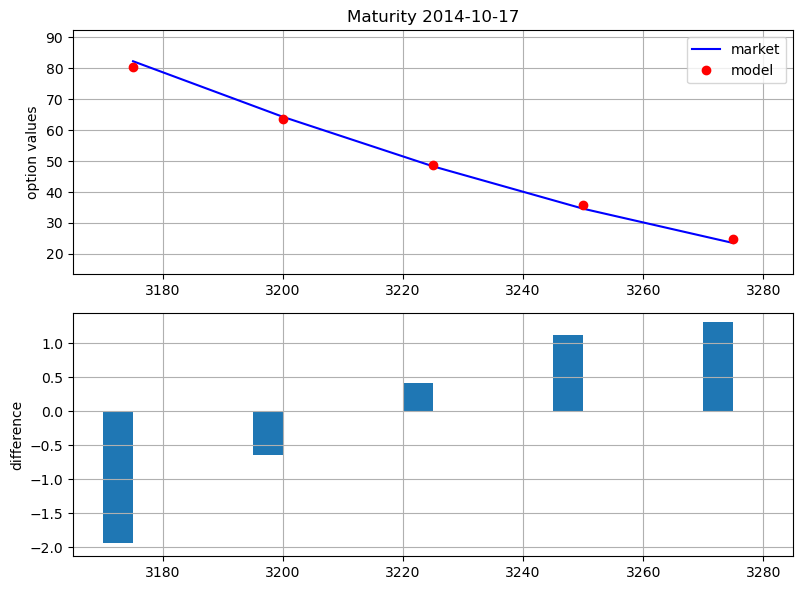

In [33]:
def BCC_calculate_model_values(p0):
    """Calculates all model values given parameter vector p0."""
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0
    values = []
    for row, option in options.iterrows():
        model_value = BCC_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        values.append(model_value)
    return np.array(values)

def plot_BCC_full(p0):
    options["Model"] = BCC_calculate_model_values(p0)
    plt.figure(figsize=(8, 6))
    plt.subplot(211)
    plt.grid()
    plt.title("Maturity %s" % str(options["Maturity"].iloc[0])[:10])
    plt.ylabel("option values")
    plt.plot(options.Strike, options.Call, "b", label="market")
    plt.plot(options.Strike, options.Model, "ro", label="model")
    plt.legend(loc=0)
    plt.axis(
        [
            min(options.Strike) - 10,
            max(options.Strike) + 10,
            min(options.Call) - 10,
            max(options.Call) + 10,
        ]
    )
    plt.subplot(212)
    plt.grid()
    wi = 5.0
    diffs = options.Model.values - options.Call.values
    plt.bar(options.Strike.values - wi / 2, diffs, width=wi)
    plt.ylabel("difference")
    plt.axis(
        [
            min(options.Strike) - 10,
            max(options.Strike) + 10,
            min(diffs) * 1.1,
            max(diffs) * 1.1,
        ]
    )
    plt.tight_layout()

plot_BCC_full(params_BCC)

As you can see, we do a very decent job in matching option market prices.

Of course, if we had fully calibrated the model for 3 different maturities at the same time, which is very demanding in terms of the actual fit of the model, we would not get such close results. We encourage you to do this and/or repeat it for a different maturity.

This also begs the question of which maturity (or maturities) we should consider when calibrating the model. This is indeed a tricky question. In principle, your pricing horizon will dictate this, but in terms of dynamically hedging your position, you would likely prefer parameter estimates that are close to current situations. 